# Financial_Resilience Challenge - Codex


## SET-UP
1.	We used the data provided by Zindi Africa (retrieved from https://drive.google.com/file/d/1vVDAaLzyhlvwm3gZGgj-4mxRqLCnsEvB/view). The dataset folder included the Train.csv for trainning our model, a Test.csv file upon which we validated the accuracy of our models. The dataset also provided us with a VariableDefinitions.csv file and a SampleSubmission.csv file.

2.	We leveraged on the Starter Notebook provided by Zindi Africa and Google collaboratory was the online platform we used for our work.


## INSTRUCTIONS ON RUNNING THE NOTEBOOK
Option 1: Running the notebook locally(In Jupyter Notebook or Any Other Means)
1.	Ensure the Train.csv, Test.csv and SampleSubmision.csv files are in the same folder as the Financial_Resilience_Python_StarterNotebook_Code.ipynb notebook.
2.	Update the path of the above mentioned files inside the notebook and then run the notebook
3.	Do ensure to have the latest version of the catboost package installed before running the notebook

Option 2: Running the notebook via Google Collaboratory
1.	Upload the Train.csv, Test.csv and SampleSubmision.csv files into your Google drive.
2.	Update the path of the above mentioned files inside the pandas(pd).read_csv dataFrame and then run the notebook.


#### Mounting Google drive to get access to dataset that has been uploaded to a folder in the cloud drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing the catboost library.

In [ ]:
!pip install catboost

In [ ]:
# Import libraries
import pandas as pd

import catboost as cgb

import numpy as np
from scipy import stats
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
pd.set_option('max_colwidth', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import missingno as msno
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load files
train = pd.read_csv('/content/drive/MyDrive/Datasets/Unlocked_FinancialResilience/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/Unlocked_FinancialResilience/Test.csv')
samplesubmission = pd.read_csv('/content/drive/MyDrive/Datasets/Unlocked_FinancialResilience/SampleSubmission.csv')
variable_definations = pd.read_csv('/content/drive/MyDrive/Datasets/Unlocked_FinancialResilience/VariableDefinitions.csv')

In [ ]:
train.shape

(104867, 36)

In [ ]:
#testing
drop_cols = ['Q7', 'Q3']

In [ ]:
full_df = [train, test]

for df in full_df:
  df.drop(columns=drop_cols, inplace=True)

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (149810, 34)


In [ ]:
# Category columns
cat_cols = [ 'owns_mobile'] + [x for x in all_data.columns if x.startswith('Q')]
num_cols = ['age', 'population']

# Change columns to their respective datatypes
all_data[cat_cols] = all_data[cat_cols].astype('category')

# Confirm whether the changes have been successful
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149810 entries, 0 to 149809
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ID           149810 non-null  object  
 1   country      149810 non-null  object  
 2   region       148830 non-null  object  
 3   population   149810 non-null  float64 
 4   age          149399 non-null  float64 
 5   Q1           149810 non-null  category
 6   Q2           68137 non-null   category
 7   Q4           82004 non-null   category
 8   Q5           82004 non-null   category
 9   Q6           149810 non-null  category
 10  Q8           84272 non-null   category
 11  Q9           84272 non-null   category
 12  Q10a         149810 non-null  category
 13  Q10b         149810 non-null  category
 14  Q11          149810 non-null  category
 15  Q12          149810 non-null  category
 16  Q13a         149810 non-null  category
 17  Q14          149810 non-null  category
 18  Q15 

In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in cat_cols:
    all_data[col+'_imputed'] = np.where(all_data[col].isnull(), 1, 0)
    
    all_data[col] = all_data[col].fillna(3) 
    
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(int(all_data[col].mean()))

cols = ['country', 'region']

for col in cols:
  all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
all_data[all_data.columns.difference(['target'])].isna().sum().any()

False

In [ ]:
train.describe()

,population,age,Q1,Q2,Q4,Q5,Q6,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target
count,1.048670e+05,104580.000000,104867.000000,47721.000000,57445.000000,57445.000000,104867.000000,59029.000000,59029.000000,104867.000000,104867.000000,104867.000000,104867.000000,104867.000000,104867.000000,104867.000000,104867.000000,104867.00000,104867.000000,80694.000000,80694.000000,104867.000000,104867.000000,37580.000000,104867.000000,104867.000000,80694.000000,58429.000000,104866.000000,73862.000000,104867.000000
mean,6.728827e+07,41.820922,1.556000,1.060078,1.618835,1.556202,1.818542,1.220485,1.202731,1.790096,1.808844,1.868395,1.791708,1.764845,1.873688,1.906462,1.937950,1.88495,1.780284,1.806516,1.777592,1.432052,1.650252,1.745796,1.861930,1.880801,1.855565,1.846378,1.176377,1.125586,0.581794
std,2.095529e+08,17.823733,0.522745,0.274234,0.496068,0.509122,0.429471,0.439298,0.427405,0.431371,0.421493,0.377230,0.442498,0.458665,0.357184,0.319899,0.268557,0.34881,0.436764,0.419319,0.441143,0.516419,0.498633,0.452266,0.375167,0.357280,0.375795,0.393282,0.394253,0.343106,0.493267
min,3.739912e+05,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4.335264e+06,27.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,9.386639e+06,39.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,3.051912e+07,55.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
max,1.134634e+09,99.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


In [ ]:
all_data['is_africa'] = np.where(all_data.region.str.contains('Africa'), 1, 0)
all_data['is_america'] = np.where(all_data.region.str.contains('America'), 1, 0)
all_data['is_europe'] = np.where(all_data.region.str.contains('Europe'), 1, 0)
all_data['is_asia'] = np.where(all_data.region.str.contains('Asia'), 1, 0)
all_data['is_high_income'] = np.where(all_data.region.str.contains('High income'), 1, 0)

In [ ]:
# Use one hot encoding to turn categorical features to numerical features
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols + cols)

In [ ]:
big_cols = ['population']

encoder = StandardScaler()

all_data[big_cols] = encoder.fit_transform(all_data[big_cols])


In [ ]:
all_data.loc[(all_data.age) <= 20, 'age'] = 1 #2
all_data.loc[(all_data.age > 20) & (all_data.age <= 30), 'age'] = 1 
all_data.loc[(all_data.age > 30) & (all_data.age <= 50), 'age'] = 2 #1
all_data.loc[(all_data.age > 50) & (all_data.age <= 60), 'age'] = 3 #3
all_data.loc[(all_data.age > 60), 'age'] = 4 #4

In [ ]:
all_data.head()

,ID,population,age,target,Q1_imputed,Q2_imputed,Q4_imputed,Q5_imputed,Q6_imputed,Q8_imputed,Q9_imputed,Q10a_imputed,Q10b_imputed,Q11_imputed,Q12_imputed,Q13a_imputed,Q14_imputed,Q15_imputed,Q16_imputed,Q17a_imputed,Q17b_imputed,Q19_imputed,Q20_imputed,Q21_imputed,Q22_imputed,Q23_imputed,Q24_imputed,Q25_imputed,Q26_imputed,Q27_imputed,owns_mobile_imputed,Q28_imputed,is_africa,is_america,is_europe,is_asia,is_high_income,owns_mobile_1.0,owns_mobile_2.0,owns_mobile_3.0,...,country_Serbia,country_Sierra Leone,country_Singapore,country_Slovak Republic,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sweden,country_Switzerland,"country_Taiwan, China",country_Tajikistan,country_Tanzania,country_Thailand,country_Togo,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,"country_Venezuela, RB",country_Vietnam,country_West Bank and Gaza,country_Zambia,country_Zimbabwe,region_East Asia & Pacific (excluding high income),region_Europe & Central Asia (excluding high income),region_High income: OECD,region_High income: nonOECD,region_Latin America & Caribbean (excluding high income),region_Middle East & North Africa (excluding high income),region_South Asia,region_Sub-Saharan Africa (excluding high income)
0,ID_0000020532,-0.200858,4.0,0.0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,ID_0000075765,-0.300261,2.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,ID_0000085491,-0.200858,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,ID_0000144505,-0.177424,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,ID_0000214184,0.119050,2.0,1.0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
all_data.age = all_data.age.astype(int)

In [ ]:
all_data.head()

,ID,population,age,target,Q1_imputed,Q2_imputed,Q4_imputed,Q5_imputed,Q6_imputed,Q8_imputed,Q9_imputed,Q10a_imputed,Q10b_imputed,Q11_imputed,Q12_imputed,Q13a_imputed,Q14_imputed,Q15_imputed,Q16_imputed,Q17a_imputed,Q17b_imputed,Q19_imputed,Q20_imputed,Q21_imputed,Q22_imputed,Q23_imputed,Q24_imputed,Q25_imputed,Q26_imputed,Q27_imputed,owns_mobile_imputed,Q28_imputed,is_africa,is_america,is_europe,is_asia,is_high_income,owns_mobile_1.0,owns_mobile_2.0,owns_mobile_3.0,...,country_Serbia,country_Sierra Leone,country_Singapore,country_Slovak Republic,country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sweden,country_Switzerland,"country_Taiwan, China",country_Tajikistan,country_Tanzania,country_Thailand,country_Togo,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,"country_Venezuela, RB",country_Vietnam,country_West Bank and Gaza,country_Zambia,country_Zimbabwe,region_East Asia & Pacific (excluding high income),region_Europe & Central Asia (excluding high income),region_High income: OECD,region_High income: nonOECD,region_Latin America & Caribbean (excluding high income),region_Middle East & North Africa (excluding high income),region_South Asia,region_Sub-Saharan Africa (excluding high income)
0,ID_0000020532,-0.200858,4,0.0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,ID_0000075765,-0.300261,2,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,ID_0000085491,-0.200858,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,ID_0000144505,-0.177424,2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,ID_0000214184,0.119050,2,1.0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((104867, 301), (44943, 301))

In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['ID', 'target'])
X = train_df[main_cols]
y = train_df.target.astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=122, stratify=y)

In [ ]:
# Train model
cgb_model = cgb.CatBoostClassifier(
                                    verbose=1, 
                                    learning_rate=0.007,
                                    border_count= 25, 
                                   iterations= 17000, 
                                   loss_function='Logloss',
                                   depth=6,
                                   min_data_in_leaf = 1,
                                   l2_leaf_reg= 6,
                                   task_type='GPU', 
                                 )

cgb_model.fit(X_train, y_train)

# Make predictionsn
y_pred = cgb_model.predict_proba(X_test)[:, 1]

# Check the auc score of the model
print(f'LGBM AUC score on the X_test is: {roc_auc_score(y_test, y_pred)}\n')

# print classification report
print(classification_report(y_test, [1 if x >= 0.5 else 0 for x in y_pred]))


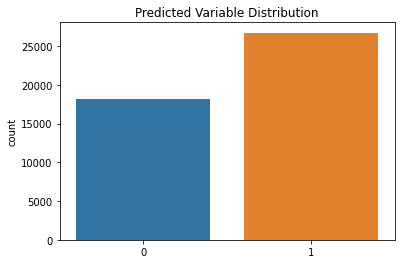

In [ ]:
# Make prediction on the test set

test_df = test_df[main_cols]
predictions = cgb_model.predict_proba(test_df)[:, 1]

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.target = predictions

# # Check the distribution of your predictions
sns.countplot([1 if x >= 0.5 else 0 for x in sub_file.target])
plt.title('Predicted Variable Distribution');

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Submission_File.csv', index = False)
sub_file.head(10)

,ID,target
0,ID_0000005111,0.857982
1,ID_0000389416,0.200251
2,ID_0000634789,0.471538
3,ID_0000778100,0.973650
4,ID_0001123210,0.531863
5,ID_0001249054,0.916194
6,ID_0001660561,0.647511
7,ID_0002213924,0.287126
8,ID_0002486764,0.464264
9,ID_0002553917,0.943829


## THE END